# 03 | Testing on Real Data

In this notebook we'll run through an entire subject's resting state EPI scan using each of the interfaces that have been built. After running through we'll examine and compare some example voxel time signals.

In [1]:
import copy

import numpy as np
import pandas as pd

import nibabel as nib
import nilearn.image as nimg
import nilearn.datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
import nilearn.plotting

from confounds import censor_method

import seaborn as sns
import matplotlib.pyplot as plt

We're using MNI data here so that we can apply a parcellation to compare connectivity matrices after fitting

In [6]:
data_dir = '../../data/debugging_data/'
file_spec = 'sub-LA1LA10056_ses-01_task-rest_run-1'
f_bold = f'{data_dir}/{file_spec}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
f_confounds =f'{data_dir}/{file_spec}_desc-confounds_timeseries.tsv'

Set up parcellation to use to pull connectivity information

In [7]:
schaefer_result = nilearn.datasets.fetch_atlas_schaefer_2018(
    data_dir='../data/atlases/')

In [8]:
schaefer_orig = nimg.load_img(schaefer_result['maps'])

Set up regressor dataframe and pull FD trace

In [9]:
conf_df = pd.read_csv(f_confounds, delimiter="\t")
base_cols = [
    "trans_x", "trans_y", "trans_z",
    "rot_x", "rot_y", "rot_z",
    "csf", "white_matter", "global_signal"
]

sq = True
deriv = True
sqderiv = True

all_cols = copy.copy(base_cols)
if sq:
    all_cols += [f"{f}_power2" for f in base_cols]
    
if deriv:
    all_cols += [f"{f}_derivative1" for f in base_cols]
    
if sqderiv:
    all_cols += [f"{f}_derivative1_power2" for f in base_cols]


In [10]:
clean_dict = {
    "--cf-cols": ','.join(all_cols),
    "detrend": True, "standardize": True,
    "low_pass": 0.08,
    "high_pass": 0.009
}

In [11]:
bold_img = nimg.load_img(f_bold)
schaefer = nimg.resample_to_img(source_img=schaefer_orig,
                               target_img=bold_img,
                               interpolation="nearest")

In [12]:
def derive_connectivity(img, confounds, parcellation, 
                        censor_algo):
    '''
    Given an image, confounds, parcellation and configured
    censoring algorithm, extract a pearson correlation matrix
    '''
    
    res = censor_algo.transform(img, confounds)
    masker = NiftiLabelsMasker(labels_img = parcellation,
                              smoothing_fwhm=6)
    res = masker.fit_transform(res)
    connectome_measure = ConnectivityMeasure(kind='correlation')
    res = connectome_measure.fit_transform([res])
    return res

In [13]:
# Set up censoring algorithms
ALGOS = [
    censor_method.BaseClean,
    censor_method.PowersClean,
    censor_method.LindquistPowersClean,
    censor_method.DCTBasisClean,
    censor_method.FourierBasisClean
]

In [14]:
res = []
for a in ALGOS:
    res.append(
        derive_connectivity(
            bold_img,
            conf_df,
            schaefer,
            a(clean_dict)
        )
    )   

In [16]:
connectivity_matrices = [a[0] for a in res]

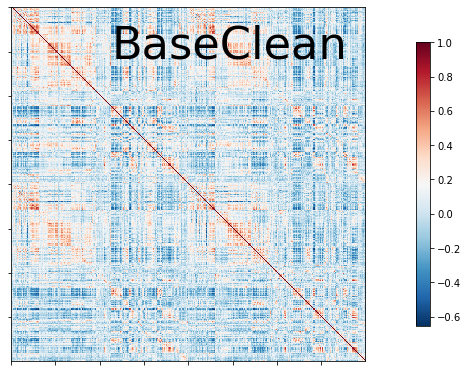

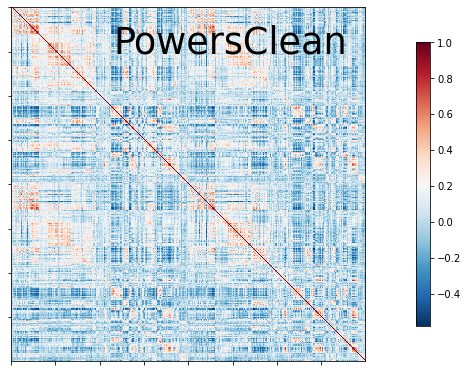

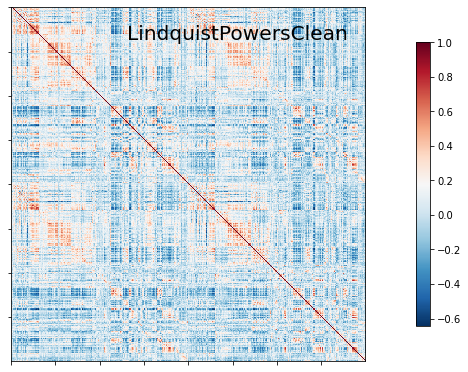

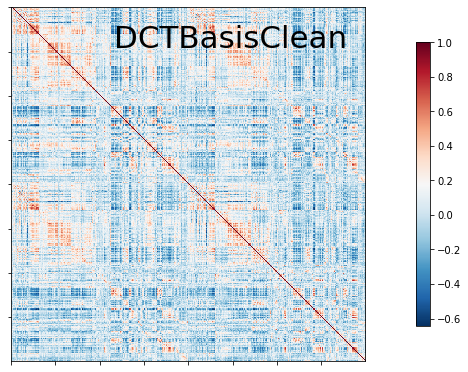

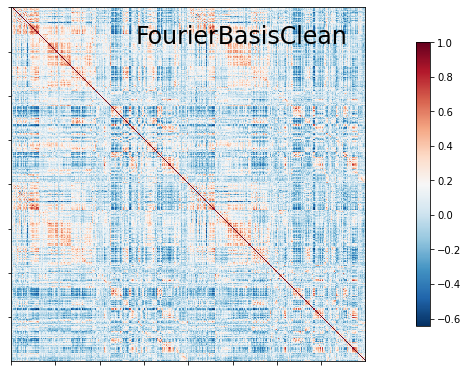

In [17]:
for a,m in zip(ALGOS, connectivity_matrices):
    nilearn.plotting.plot_matrix(m,title=a.__name__)

Make sure we don't have a weird glitch where every pipeline is identical...

In [18]:
from itertools import combinations

In [30]:
# Link with algorithm
comparisons = [(a.__name__, b) for a, b 
               in zip(ALGOS, connectivity_matrices)]

In [35]:
for a, b in combinations(comparisons, 2):
    a_algo = a[0]
    a_m = a[1]
    b_algo = b[0]
    b_m = b[1]
    
    if np.array_equal(a_m, b_m):
        print(f"{a_algo} matches {b_algo}")

LindquistPowersClean matches DCTBasisClean
LindquistPowersClean matches FourierBasisClean
DCTBasisClean matches FourierBasisClean
